# Solubility Prediction from Molecular Descriptors

The following notebook builds upon the dataset introduced and explore in the `data_analysis.ipynb` IPython notebook. Specifically, we load our created data file into this notebook, prepare it for use by two different machine learning algorithms &mdash; random forest and neural network &mdash; and train these two models to find the best model for predicting solubility.

As always, we start by importing the relevant Python packages.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import KFold, cross_validate, train_test_split
from sklearn.pipeline import make_pipeline

## Data Loading, Splitting and Standardisation

The data can be loaded in a similar fashion to the single files in the previous notebook. Note, however, that if you saved the file in the previous notebook as an Excel document then you need to use the `pd.read_excel` function as opposed to the `pd.read_csv` function.

### Excercise 1: Loading Data

Load the dataset curated during the `data_analysis.ipynb` IPython notebook into a Pandas `DataFrame` and check it is the right data.

In [2]:
df = pd.read_excel("../solubility.xlsx")

In [3]:
df

,solvent_name,solute_name,solubility_g_100g,solute_a_nC,solute_a_nN,solute_a_nO,solute_b_heavy,solute_b_rotN,solute_lip_acc,solute_lip_don,...,solute_TPSA,solvent_a_nC,solvent_a_nN,solvent_a_nO,solvent_b_heavy,solvent_b_rotN,solvent_lip_acc,solvent_lip_don,solvent_rings,solvent_TPSA
0,1-Propanol,"(2R,3R,4R,5S)-hexane-1,2,3,4,5,6-hexol",0.375750,6,0,6,11,5,6,6,...,121.38,3,0,1,3,1,1,1,0,20.230000
1,Acetone,"(2R,3R,4R,5S)-hexane-1,2,3,4,5,6-hexol",0.119860,6,0,6,11,5,6,6,...,121.38,3,0,1,3,0,1,0,0,17.070000
2,1-Butanol,"(2R,3R,4R,5S)-hexane-1,2,3,4,5,6-hexol",0.220160,6,0,6,11,5,6,6,...,121.38,4,0,1,4,2,1,1,0,20.230000
3,Acetonitrile,"(2R,3R,4R,5S)-hexane-1,2,3,4,5,6-hexol",0.092300,6,0,6,11,5,6,6,...,121.38,2,1,0,2,0,1,0,0,23.790001
4,Methanol,"(2R,3R,4R,5S)-hexane-1,2,3,4,5,6-hexol",3.347240,6,0,6,11,5,6,6,...,121.38,1,0,1,1,0,1,1,0,20.230000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
628,1-Butanol,trimethoprim,0.248834,14,4,3,22,5,7,4,...,105.51,4,0,1,4,2,1,1,0,20.230000
629,2-Butanol,trimethoprim,0.220364,14,4,3,22,5,7,4,...,105.51,4,0,1,4,1,1,1,0,20.230000
630,Methanol,trimethoprim,1.568378,14,4,3,22,5,7,4,...,105.51,1,0,1,1,0,1,1,0,20.230000
631,Tetrahydrofuran,trimethoprim,0.472030,14,4,3,22,5,7,4,...,105.51,4,0,1,5,0,1,0,1,9.229999


The relevant data must now be extracted to be used when training and testing the models. This will be accomplished in two steps:

1. Extracting the data from the `DataFrame`
2. Splitting this data into a training and testing dataset

### Exercise 2: Extracting the Data from the `DataFrame`

We must extract what we want to be the inputs and the outputs to the ML model from the `DataFrame`. This can be achieved by creating two subsets of the `DataFrame` (as done before in the `data_analysis.ipynb` notebook) one containing only the inputs and one the outputs.

Create two variables `X` and `y` where `X` will represent the input to the models and `y` will represent the output to the models.

Hint: you can define a list of all the features you want to use in your model and use that when splitting up the `DataFrame` e.g. [here](https://www.ritchieng.com/pandas-scikit-learn/).

In [4]:
feature_columns = df.columns[3:]

In [5]:
feature_columns

Index(['solute_a_nC', 'solute_a_nN', 'solute_a_nO', 'solute_b_heavy',
       'solute_b_rotN', 'solute_lip_acc', 'solute_lip_don', 'solute_rings',
       'solute_TPSA', 'solvent_a_nC', 'solvent_a_nN', 'solvent_a_nO',
       'solvent_b_heavy', 'solvent_b_rotN', 'solvent_lip_acc',
       'solvent_lip_don', 'solvent_rings', 'solvent_TPSA'],
      dtype='object')

In [6]:
X = df[feature_columns]
y = df["solubility_g_100g"]

In [7]:
X

,solute_a_nC,solute_a_nN,solute_a_nO,solute_b_heavy,solute_b_rotN,solute_lip_acc,solute_lip_don,solute_rings,solute_TPSA,solvent_a_nC,solvent_a_nN,solvent_a_nO,solvent_b_heavy,solvent_b_rotN,solvent_lip_acc,solvent_lip_don,solvent_rings,solvent_TPSA
0,6,0,6,11,5,6,6,0,121.38,3,0,1,3,1,1,1,0,20.230000
1,6,0,6,11,5,6,6,0,121.38,3,0,1,3,0,1,0,0,17.070000
2,6,0,6,11,5,6,6,0,121.38,4,0,1,4,2,1,1,0,20.230000
3,6,0,6,11,5,6,6,0,121.38,2,1,0,2,0,1,0,0,23.790001
4,6,0,6,11,5,6,6,0,121.38,1,0,1,1,0,1,1,0,20.230000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
628,14,4,3,22,5,7,4,2,105.51,4,0,1,4,2,1,1,0,20.230000
629,14,4,3,22,5,7,4,2,105.51,4,0,1,4,1,1,1,0,20.230000
630,14,4,3,22,5,7,4,2,105.51,1,0,1,1,0,1,1,0,20.230000
631,14,4,3,22,5,7,4,2,105.51,4,0,1,5,0,1,0,1,9.229999


In [8]:
y

0      0.375750
1      0.119860
2      0.220160
3      0.092300
4      3.347240
         ...   
628    0.248834
629    0.220364
630    1.568378
631    0.472030
632    0.223188
Name: solubility_g_100g, Length: 633, dtype: float64

### Splitting the Data into Training and Validating and Standardising

scikit-learn contains a `train_test_split` function to allow for the easy splitting up of the data. By default this splits the data into 75% training and 25% testing, however we will change this to be 80% training and 20% testing.

For more information see the [documentation](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html).

In [9]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

Now the data has been split into training and validation data with the validation being 20% of the dataset (defined by argument `test_size=0.2`). `random_state` determines how the data is randomly split between the training and validation set. The idea is that your data will be complete enough that taking a random selection out will not change the data distribution. (We will see later that this is not necessarily the case and there are ways around this).

The data now needs to be standardised as covered in the slides. This is accomplished using `StandardScaler` from scikit-learn. First a `StandardScaler` object must be [defined](https://scikit-learn.org/stable/modules/preprocessing.html):

In [10]:
ss = StandardScaler()

Each feature of the data (each `DataFrame` column) is scaled independently, with the assumption that the values for each feature is drawn from the same probability distribution. To find the scaling required for each feature we use the `.fit` function of the `StandardScaler` (it basically works out the mean and standard deviation of each feature).

In [11]:
ss.fit(X_train)

StandardScaler()

Note that the `StandardScaler` uses the training data to scale **all** of the data as it is assumed that the validation points will be drawn from the same data distribution as the training points. Now we need to actually scale the points using

In [12]:
X_train_scaled = ss.transform(X_train)
X_val_scaled = ss.transform(X_val)

The inputs are not the only data scaled however. It was found that the ML models fit this dataset better when they are logged (see [here](https://scikit-learn.org/stable/auto_examples/compose/plot_transformed_target.html#sphx-glr-auto-examples-compose-plot-transformed-target-py) for some explanation as to why this might be). Therefore we log the outputs of the data using

In [13]:
y_train_scaled = np.log10(y_train)
y_val_scaled = np.log10(y_val)

## Model Fitting and Predictions

The following will now implement two different machine learning models &mdash; random forest and neural network &mdash; to learn to predict solubility from our features.

### Random Forests

A random forest (RF) is a collection of decision trees. A decision tree makes a prediction about a data point based on certain conditions of the features. This can be thought of as a branching path where the tree has a starting condition which splits the data one way or the other. The two subsequent conditions then split the data further and so on and so forth until the response is predicted correctly. e.g.

![Decision Tree](images/decision_tree.png)

This decision tree is used figure out if an animal is a squirrel, rat, rhino, hippo, elephant or giraffe based on some of its characteristics. This is what we want a decision tree to do. However for data such as ours, the splits that need to be considered are less obvious. Therefore we must try a bunch of different splits of the features and see which gives the best predictions. This is how a decision tree is trained. For a good albeit corny explanation of how decision trees work see the videos [here](https://www.youtube.com/watch?v=ZVR2Way4nwQ) and [here](https://www.youtube.com/watch?v=UhY5vPfQIrA).

A random forest is then just a collection of these decision trees which are formulated on a subset of the features. The idea is to get as many predictions as possible and average them to get the prediction from the entire forest (or in the case of classification each tree would get a vote). For a more in-depth explanation of a RF please see the video [here](https://www.youtube.com/watch?v=v6VJ2RO66Ag).

Now we will implement the RF algorithm to try to predict our validation data. At the start of the script we imported the `RandomForestRegressor` which is what we will be using for the model (more information can be found [here](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html) and [here](https://scikit-learn.org/stable/modules/ensemble.html#forest)). The main parameter we need to think about when implementing a random forest is the number of decision trees to include in it. By default, scikit-learn uses 100 but we will use 500 (because that's what Tony said to use).


### Exercise 1: Defining the Model
Change the following line of code to include 500 trees rather than 100

In [14]:
rfr = RandomForestRegressor(n_estimators=500, max_features="sqrt")

Now the RF must be fit to the data using the `.fit` functions similar to how it works with the `StandardScaler` but this time we need both input and output.

### Exercise 2: Fit the Model
Fit the model to the training data.

In [15]:
rfr.fit(X_train_scaled, y_train_scaled)

RandomForestRegressor(max_features='sqrt', n_estimators=500)

### Exercise 3: Evaluate the Model

There are now two functions that we can use to evaluate the performance of the model:

* `.predict` which will predict outputs based on inputs passed to it
* `.score` will return the [coefficient of determination](https://en.wikipedia.org/wiki/Coefficient_of_determination) ($R^{2}$ score) of the model which is just a measure of how well the model predicts unseen data ($R^{2}$ = 1 means the model perfectly predicts all validation data with 0 being the worst it can get).

The aim of this exercise is to predict the solubility values of the validation points and compare it with the actual solubility points of the validation points.

Using `.predict` will return a list of numbers of predicted solubility, this can then be plotted against the actual solubility to visualise how well our model performs. This plot can be thought of a visualisation of an $R^{2}$ score since the higher the $R^{2}$ score the more like a straight line this plot will look, for more info see [here](https://stats.stackexchange.com/questions/104622/what-does-an-actual-vs-fitted-graph-tell-us).

So create a variable `y_pred` to contain the predicted log solubility values and then run the plotting code below to see how well the model fits unseen data. Does it fit well? Do you expect $R^{2}$ to be close to 1, close to 0?

In [16]:
y_pred = rfr.predict(X_val_scaled)

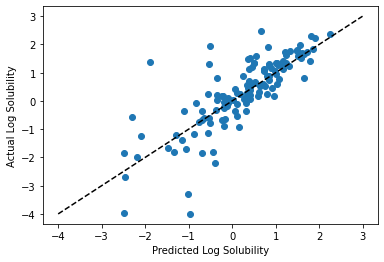

In [17]:
plt.figure()
plt.scatter(y_pred, y_val_scaled)
plt.xlabel("Predicted Log Solubility")
plt.ylabel("Actual Log Solubility")
plt.plot([-4, 3], [-4, 3], "--k")

To affirm what the plot above tells us, the $R^{2}$ score is calculated. Create a variable called `rf_r2` to store the $R^{2}$ score and then print it.

In [18]:
rf_r2 = rfr.score(X_val_scaled, y_val_scaled)

In [19]:
rf_r2

0.6311598485897367

### Neural Networks

The second type of model we will fit to our data is a deep neural network &mdash; particularly the multilayer perceptron (MLP) model. Neural networks are quite possibly the most well-known ML technique and for good reason &mdash; they are good at learning.

The structure of neural networks is relatively easy to understand. They are based on 1950s knowledge of how pathways in the brain work. Consider a neuron in the brain. It will receive some information and then pass an electrical signal based on its response to that information. Now there can be many different neurons interpreting the same information all designed to send different electrical signals to different places. This forms the basis for how neural networks work. In our artificial system each neuron is referred to as a *node* and each set of nodes which processes the same information is called a *layer*. A "perceptron" is the original name for a neural network which processes information with a single layer and makes a prediction based on the outputs of each node. Therefore a multilayer perceptron is a modification of this neural network where we use multiple layers. That is, the initial input data is fed into the first layer but then the outputs of the first layer are used as the inputs to the second and so on until an output layer is reached where a prediction is made.

How does something like this learn? The data passed to each nodes is transformed via a composition of a linear and non-linear functions. The linear function is parameterised by a set of numbers known as the *learnable parameters*. These learnable parameters start off random with the network making random predictions. The prediction is then compared with the true output value using an MSE metric and this informs the network how to change these learnable parameters to get a better prediction on the output.

The actual implementation and maths behind how neural networks work is not important here, what is important is that you understand how to apply a network and how they can be used for predictions. Similar to how we can choose the number of decission trees in a random forest, the number of nodes per layer of a network can be set to give more or less learnable parameters in the system.

The following code will be using the `MLPRegressor` from scikit-learn (more information [here](https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPRegressor.html#sklearn.neural_network.MLPRegressor)).

### Exercise 1: Defining the Model

An `MLPRegressor` model can be defined similarly to a `RandomForestRegressor` but this time we would like to set `hidden_layer_sizes = (1000,)` and `max_iter = 10000`.

In [27]:
mlp = MLPRegressor(hidden_layer_sizes=(1000,), max_iter=10000)

By default the `MLPRegressor` neural network has **3** layers so setting `hidden_layer_sizes = (1000,)` will construct a 3 layer network where each layer has 1000 nodes.

### Exercise 2: Fitting the Model

Using the same `.fit` function as for the random forest we can fit our neural network to our training data.

In [28]:
mlp.fit(X_train_scaled, y_train_scaled)

MLPRegressor(hidden_layer_sizes=(1000,), max_iter=10000)

### Exercise 3: Evalute the Model

And again we can evaluate the model, including the actual vs. predicted plot and the $R^{2}$ score using the `.predict` and `.score` functions.

In [29]:
y_pred = mlp.predict(X_val_scaled)

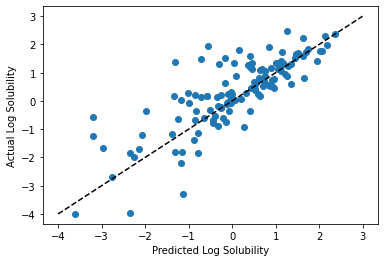

In [34]:
plt.figure()
plt.scatter(y_pred, y_val_scaled)
plt.xlabel("Predicted Log Solubility")
plt.ylabel("Actual Log Solubility")
plt.plot([-4, 3], [-4, 3], "--k")

In [32]:
mlp_r2 = mlp.score(X_val_scaled, y_val_scaled)

In [33]:
mlp_r2

0.5822733245369744

### Comparing the Two Models

Which model is better? Are you surprised?

## Model Improvement

The models we have used here are not **amazing**. This could be due to a variety of factors:

1. The training dataset is not representative of the true data distribution therefore application to unseen validation is worse.
2. The model parameters are not optimal for learning the problem e.g. more/less trees needed, more/less nodes/layers needed.

For the last part of the exercise we will focus on 1. ([However, 2. can be addressed by performing a grid search over a bunch of the parameters in the model and seeing which performs the best](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html)).

When we split the data into training and validation using the `train_test_split` function we choose `random_state = 42` randomly. This split up the data into training and validation but may not have split them in an optimal way. That is, the standardisation and model are fitted to the training data so there is an underlying assumption that the training data is representative of the true data distribution. For some splits of the data this may not be the case however and the model may be learning from a bad subset of the data which teaches the model the wrong distribution therefore making the predictions more erroneous.

To counter this we perform what is known as *cross validation*. This is when many models are trained on different splits of training and validation data and the model with the average result over all tests used as an indicator of how well our model would perform regardless of dataset permutation. In the code this is implemented through a combination of `KFold` and `cross_validate` to perform *K-Fold cross validation*. K-Fold cross validation just means that the data is split K different times and the model is trained on K subsets of data (typical values are 5, 10, 20). So performing this in the code we must first define a `KFold` object which will tell the `cross_validate` function e.g.

In [35]:
kf = KFold(n_splits=20, shuffle=True, random_state=42)

In [36]:
pipe = make_pipeline(StandardScaler(), RandomForestRegressor(n_estimators=500, max_features="sqrt"))

In [37]:
y = np.log10(y)

In [38]:
cval = cross_validate(pipe, X, y, cv=kf, return_estimator=True)

A bit of an explanation for the code above. Since we are doing different dataset splits for each model, the `StandardScaler` must be fitted to each new set of training data. This is where the `make_pipeline` function comes in. This allows us to join together various features in scikit-learn into one workflow to be executed in sequence (see [here](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.make_pipeline.html)). Therefore, rather than just fitting a model, we now have the `StandardScaler` applied and then the model is applied. The `cross_validation` function itself expects the model pipeline, the input data, the output data and the K-fold to be used. We set `return_estimator = True` to also return the trained models.

`cross_validate` [returns a dictionary](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_validate.html) with four keys:

1. `test_score` &mdash; this is the $R^{2}$ of the model
2. `estimator` &mdash; this is a list of the trained models
3. `fit_time` &mdash; how long in seconds it took to fit the model
4. `score_time` &mdash; how long in seconds it took to score the validation dataset

### Exercise 1: Viewing the K-fold Cross Validation Results

View this dictionary by printing it below.

In [39]:
cval

{'fit_time': array([0.55292606, 0.48178267, 0.49253392, 0.52175212, 0.52669764,
        0.51387858, 0.48750329, 0.52895927, 0.47129178, 0.56034255,
        0.48947835, 0.56910872, 0.49909139, 0.49259615, 0.51818919,
        0.48870206, 0.49863815, 0.52487683, 0.49998665, 0.52241588]),
 'score_time': array([0.02170062, 0.0190196 , 0.03191853, 0.03123593, 0.00757861,
        0.01561213, 0.03116822, 0.03175402, 0.01561379, 0.03125358,
        0.02168989, 0.03240681, 0.01308036, 0.03133249, 0.01935577,
        0.01561689, 0.02200007, 0.03132319, 0.02599978, 0.02878666]),
 'estimator': [Pipeline(steps=[('standardscaler', StandardScaler()),
                  ('randomforestregressor',
                   RandomForestRegressor(max_features='sqrt', n_estimators=500))]),
  Pipeline(steps=[('standardscaler', StandardScaler()),
                  ('randomforestregressor',
                   RandomForestRegressor(max_features='sqrt', n_estimators=500))]),
  Pipeline(steps=[('standardscaler', Standard

Now print just the `test_score` entry of the dictionary to see the results

In [40]:
cval["test_score"]

array([0.57309471, 0.65787078, 0.66002266, 0.53606309, 0.80506419,
       0.81111558, 0.65019937, 0.3994834 , 0.6365688 , 0.62148035,
       0.74833193, 0.46844855, 0.81675631, 0.79632088, 0.8164473 ,
       0.41158542, 0.55364769, 0.72964623, 0.66830252, 0.80096941])

### Exercise 2: Calculate the Mean and Standard Deviation of the Cross Validation Results

Hint: Google calculating mean and standard deviation using numpy.

In [41]:
np.round(np.mean(cval["test_score"]), decimals=2)

0.66

In [42]:
np.round(np.std(cval["test_score"]), decimals=2)

0.13

### Exercise 3: Do the Same As Above but for the `MLPRegressor`

In [43]:
mlp_kf = KFold(n_splits=20, shuffle=True)

In [44]:
mlp_pipe = make_pipeline(StandardScaler(), MLPRegressor(hidden_layer_sizes=(64,), max_iter=10000))

In [45]:
mlp_cval = cross_validate(mlp_pipe, X, y, cv=mlp_kf, return_estimator=True)

In [46]:
mlp_cval["test_score"]

array([0.28901316, 0.43405069, 0.39340514, 0.03051675, 0.27316989,
       0.51790646, 0.52849517, 0.38017965, 0.53440738, 0.60873206,
       0.24892521, 0.49061495, 0.47034051, 0.46149462, 0.50416059,
       0.41073316, 0.69993819, 0.33886659, 0.28887086, 0.48196007])

In [47]:
np.round(np.mean(mlp_cval["test_score"]), decimals=2)

0.42

In [48]:
np.round(np.std(mlp_cval["test_score"]), decimals=2)

0.14